In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import numpy as np
from tqdm import tqdm

In [10]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [11]:
import os
import sys
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath, "utils"))

In [12]:
from extraction_helpers import read_file
from eda_helpers import plot_missing_proportion_barchart, get_cols

In [13]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
CATEGORY_COLUMNS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [14]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Data

In [15]:
data = read_file(f"{RAW_DATA_PATH}/train_all.ftr")

Shape of data: (5531451, 191)


In [16]:
data.head(3)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0


In [18]:
column_types = dict(
    id_col = get_cols(data, "customer"),
    target_col = get_cols(data, "target"),
    payment_vars = get_cols(data, "P", first=True),
    spend_vars = get_cols(data, "S", first=True),
    risk_vars = get_cols(data, "R", first=True),
    balance_vars = get_cols(data, "B", first=True),
    delinquency_vars = get_cols(data, "D", first=True)
)

In [19]:
for col in column_types:
    print(col, len(column_types[col]))

id_col 1
target_col 1
payment_vars 3
spend_vars 22
risk_vars 28
balance_vars 40
delinquency_vars 96


In [20]:
id_col = column_types["id_col"]
target_col = column_types["target_col"]

In [21]:
count_agg_summary = data.groupby(id_col).agg(count=("S_2", "count")).reset_index()

In [30]:
temp = count_agg_summary["count"].value_counts(normalize=True)


In [37]:
temp

13    0.841192
12    0.023148
10    0.014645
9     0.013970
8     0.013314
2     0.013288
11    0.012989
3     0.012591
6     0.012018
7     0.011327
1     0.011157
4     0.010183
5     0.010178
Name: count, dtype: float64

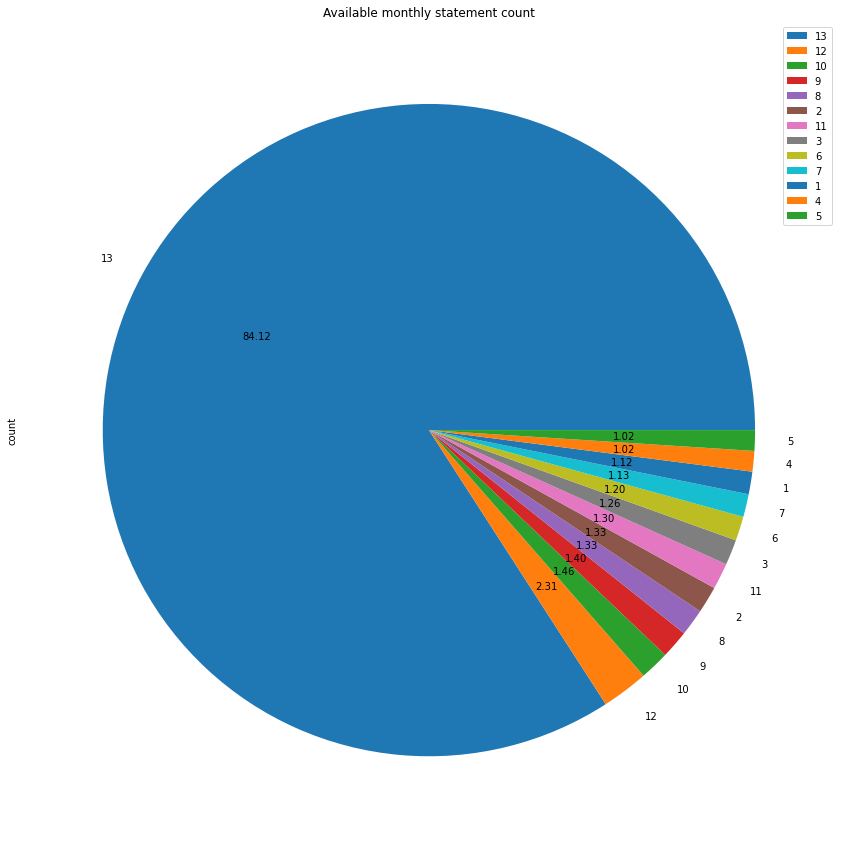

In [39]:
plt.figure(figsize=(17, 15))
temp = count_agg_summary["count"].value_counts(normalize=True)
temp.plot(kind='pie', autopct='%.2f')
plt.legend()
plt.title("Available monthly statement count")
plt.show()

In [ ]:
data = count_agg_summary.merge(data, on="customer_ID", how="left")

## EDA & Data Cleaning

In [ ]:
special_columns = ['customer_ID', 'S_2', 'target', "Date", "min_date", "max_date", "num_records", "days", "record_per_day"] \
 + get_cols(data, "has") + get_cols(data, "sign")

In [ ]:
all_cols = [c for c in data.columns if c not in special_columns]
cat_features = data.select_dtypes("category").columns.tolist()
num_features = [col for col in all_cols if col not in cat_features]

In [ ]:
len(all_cols), len(cat_features), len(num_features)

In [ ]:
num_feature_corr_df = data[num_features].corr()

In [ ]:
plt.figure(figsize=(16, 14))
sns.heatmap(num_feature_corr_df)
plt.show()

In [ ]:
customer_id_samples = data.loc[data["count"] == 13]["customer_ID"].sample(10).values.tolist()

### Payment Variables

In [ ]:
balance_variables = column_types["balance_vars"]

In [ ]:
balance_subset = data.loc[:, id_col + balance_variables + target_col]

In [ ]:
index = 70

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(18, 12))
ax = axes.ravel()
for x_label, customer_id in enumerate(customer_id_samples):
    balance_single_customer = balance_subset.loc[balance_subset["customer_ID"] == customer_id]
    ax[x_label].plot(range(len(balance_single_customer)), balance_single_customer["B_2"])
    print(balance_single_customer['target'].mean())
    # ax[x_label].text(x=0.25, y=0.95, s=f"Ground Truth: {balance_single_customer['target'].mean():.0f}")
plt.show()

### Missing value analysis (Pre Simple Imputation)

In [ ]:
missing_prop_df = plot_missing_proportion_barchart(data)

#### Simple Imputation

In [ ]:
train.loc[~train["D_134"].isnull()][["D_134", "D_135", "D_136", "D_137", "D_138"]]

In [ ]:
train[["has_D_132", "has_D_134", "has_D_135", "has_D_136", "has_D_137", "has_D_138"]].corr()

In [ ]:
amex_metric_np

In [ ]:
train.shape

In [ ]:
train.groupby("target")["B_29"].mean()

In [ ]:
train.loc[train["R_9"].isnull()]["target"].mean()

In [ ]:
train.loc[~train["R_9"].isnull()]["target"].mean()

In [ ]:
train.loc[train["B_39"].apply(lambda x: abs(x - 0) < 1e-5)]["B_39"]

In [ ]:
train["R_9"].describe()

In [ ]:
test["D_73"].describe()

In [ ]:
train["B_39"].value_counts()

#### Missing value analysis (Post Simple Imputation)

In [ ]:
missing_prop_df = plot_missing_proportion_barchart(train)

In [ ]:
for column in missing_prop_df.iloc[:20]["column"].tolist():
    print(column, "\n", high_missing_train_df[column].value_counts(), "\n")

In [ ]:
high_missing_count_columns = 

In [ ]:
high_missing_train_df = train_data.loc[:, high_missing_count_columns + ["target"]]

In [ ]:
high_missing_train_df.loc[high_missing_train_df["D_87"].isnull()]["target"].mean()

In [ ]:
high_missing_train_df.loc[~high_missing_train_df["D_87"].isnull()]["target"].mean()

In [ ]:
train_cols_unique_count = train_data.nunique()

In [ ]:
less_unique_columns = train_cols_unique_count[train_cols_unique_count <= 300].index.tolist()
print(less_unique_columns)

In [ ]:
for column in less_unique_columns:
    print(f"Column {column}")
    print(train_data[column].unique(), end="\n\n")

In [ ]:
all_cols = [c for c in train_data.columns if c not in ['customer_ID', 'S_2']]
cat_features = less_unique_columns
num_features = [col for col in all_cols if col not in less_unique_columns]

In [ ]:
len(all_cols), len(cat_features), len(num_features)

In [ ]:
def get_agg_summary(original_df):
    agg_summary = original_df.groupby("customer_ID").agg(num_records=("S_2", "count"), 
                                                         max_date=("S_2", "max"),
                                                         min_date=("S_2", "min"))
    agg_summary = agg_summary.reset_index()
    agg_summary["days"] = (agg_summary["max_date"] - agg_summary["min_date"]).dt.days
    agg_summary["record_per_day"] = agg_summary["days"] / agg_summary["num_records"]
    return agg_summary

In [ ]:
train_agg_summary = get_agg_summary(train_data)
test_agg_summary = get_agg_summary(test_data)

In [ ]:
def set_category_columns(df):
    pass

In [ ]:
train_data.loc[:, cat_features].

#### Aggregation

#### Numeric features

In [ ]:
train_data_agg = train_data.groupby("cid")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])

In [ ]:
train_data_agg.columns = ['_'.join(x) for x in train_data_agg.columns]

In [ ]:
test_data_agg = test_data.groupby("cid")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])

In [ ]:
test_data_agg.columns = ['_'.join(x) for x in test_data_agg.columns]

#### Categorical features

In [ ]:
train_cat_agg = train_data.groupby("cid")[cat_features].agg(['count', 'last', 'nunique'])
test_cat_agg = test_data.groupby("cid")[cat_features].agg(['count', 'last', 'nunique'])

In [ ]:
train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

In [ ]:
train_agg = pd.concat([train_data_agg, train_cat_agg], axis=1)
del train_data_agg, train_cat_agg

In [ ]:
train_agg = train_agg.reset_index()

In [ ]:
train_agg.shape

In [ ]:
test_agg = pd.concat([test_data_agg, test_cat_agg], axis=1)
del test_data_agg, test_cat_agg

In [ ]:
test_agg = test_agg.reset_index()

In [ ]:
test_agg.shape

### Train Val Split

In [ ]:
train_labels.insert(0, "cid", train_labels['customer_ID'].apply(hash).astype('int64'))
train_labels.head(5)

In [ ]:
train_labels = train_labels.sort_values(by="cid").reset_index(drop=True)

In [ ]:
train_ = train_agg.merge(train_labels[["cid", "target"]], on="cid", how="left")

In [ ]:
train_["dummy"] = np.random.randn(train_.shape[0])

In [ ]:
train, val = train_test_split(train_, test_size=0.2, random_state=1020, stratify=train_["target"])

In [ ]:
train["target"].mean(), val["target"].mean()

### LGBM Model

In [ ]:
X_train = train.drop(columns=["cid", "target"])
X_val = val.drop(columns=["cid", "target"])

In [ ]:
y_train = train["target"]
y_val = val["target"]

In [ ]:
opt = BayesSearchCV(
    LGBMClassifier(random_state=1020),
    {
        'learning_rate': (0.01, 0.1),
        'num_leaves': (31, 127),
        'max_depth': (4, 15),
        'min_child_samples': (15, 63),
        'n_estimators': (50, 150),
        'subsample': (0.7, 0.9),
        'subsample_freq': (2, 5),
        'colsample_bytree': (0.7, 0.9),
        'reg_lambda': (0, 10),
        'min_split_gain': (0, 0.05),
    },
    n_iter=10,
    cv=5,
    scoring=make_scorer(fbeta_score, beta=2)
)

In [ ]:
opt.fit(X_train, y_train)

In [ ]:
lgbm_clf = LGBMClassifier(random_state=1020)

In [ ]:
lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Test"], 
                title="Train Test ROC AUC")

In [ ]:
imp_df = plot_feature_importance(lgbm_clf.feature_name_, 
                                 lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
num_list, num_features_list, train_score_list, val_score_list = [], [], [], []
for i in tqdm(range(30)):
    selected_features = imp_df.loc[imp_df["feature_importance"] > i]["feature"].tolist()
    print(f"# of features: {len(selected_features)}")
    
    X_train_new = train.loc[:, selected_features]
    X_val_new = val.loc[:, selected_features]
    
    lgbm_clf = LGBMClassifier(random_state=1020)
    lgbm_clf.fit(X_train_new, y_train)
    
    y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
    y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]
    
    y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
    y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})
    y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
    y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})
    
    train_score = amex_metric(y_train_df, y_train_pred_df)
    val_score = amex_metric(y_val_df, y_val_pred_df)
    num_list.append(i)
    num_features_list.append(len(selected_features))
    train_score_list.append(train_score)
    val_score_list.append(val_score)

In [ ]:
eval_df = pd.DataFrame(dict(index_=num_list, 
                            num_feature=num_features_list, 
                            train_score=train_score_list, 
                            val_score=val_score_list))

In [ ]:
# eval_df

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(eval_df["index_"], eval_df["train_score"], label="Train")
plt.plot(eval_df["index_"], eval_df["val_score"], label="Validation")
plt.legend()
plt.show()

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 5]["feature"].tolist()
len(selected_features)

In [ ]:
X_train_new = train.loc[:, selected_features]
X_val_new = val.loc[:, selected_features]

In [ ]:
lgbm_clf.fit(X_train_new, y_train)

In [ ]:
y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Test"], 
                title="Train Test ROC AUC")

In [ ]:
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_train_df, y_train_pred_df)

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

### Inference

In [ ]:
X_test = test_agg.drop(columns=["cid"])

In [ ]:
X_test = test_agg.loc[:, selected_features]

In [ ]:
y_test_pred = lgbm_clf.predict_proba(X_test)[:, 1]

In [ ]:
test_agg["prediction"] = y_test_pred

#### Submission

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

In [ ]:
submission["cid"] = submission['customer_ID'].apply(hash).astype('int64')
submission = submission.drop(columns="prediction")

In [ ]:
result = submission.merge(test_agg[["cid", "prediction"]], on="cid").drop(columns="cid")

In [ ]:
result.to_csv(f"{SUBMISSION_DATA_PATH}/submission3.csv", index=False)